In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets

Files already downloaded and verified


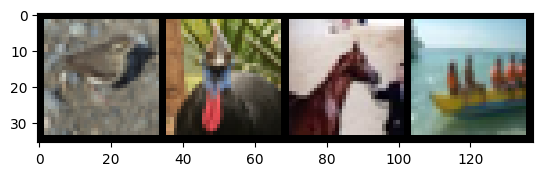

 bird  bird horse  ship


In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Visualize some images from the training set
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Load the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset_untransformed = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader_untransformed = torch.utils.data.DataLoader(trainset_untransformed, batch_size=4, shuffle=True, num_workers=2)

# Get some random training images
images, labels = next(iter(trainloader_untransformed))

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download the dataset only once
whole_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split it into train and validation sets
trainset, valset = torch.utils.data.random_split(whole_trainset, [round(len(whole_trainset)*0.9), round(len(whole_trainset)*0.1)])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, drop_last=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


In [10]:
def train_model(model, trainloader, valloader, epochs=25):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #train_losses.append(loss.item())

            running_loss += loss.item()
            # if i % 1000 == 0:
            #     print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
            #     running_loss = 0.0
        train_losses.append(running_loss/len(trainloader))
        # Calculate validation loss
        val_loss = 0.0
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_losses.append(val_loss / len(valloader))

        print(f'Epoch {epoch + 1} - Training loss: {running_loss/len(trainloader):.3f}, Validation loss: {val_loss / len(valloader):.3f}')

        scheduler.step()

    print('Finished Training')
    # return weights, gradients, activations, learning_rate, train_losses, val_losses
    # return None, None, None, None, train_losses, val_losses
    return train_losses, val_losses

In [11]:
def plot_losses(train_losses, val_losses, trainloader, title):
    # x_train = np.arange(len(train_losses))
    # x_val = np.arange(len(trainloader), len(trainloader)*(len(val_losses)+1), len(trainloader))

    plt.figure(figsize=(12,6))
    # plt.plot(x_train, train_losses, label='Training Loss', linewidth = 0.3)
    # plt.plot(x_val, val_losses, label='Validation Loss', marker='o', linestyle='-')
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss', marker='o', linestyle='-')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()


In [12]:
def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Accuracy of the network on the test images: %d %%" % (100 * correct / total))

### 1. BaseModel: FC
![Example Image](../images/feedforward.png)

In [ ]:
# 1. Fully Connected Model. Just to set the base.
class FCModel(nn.Module):
    def __init__(self):
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Training FCModel...
Epoch 1 - Training loss: 1.703, Validation loss: 1.571
Epoch 2 - Training loss: 1.505, Validation loss: 1.511
Epoch 3 - Training loss: 1.399, Validation loss: 1.470
Epoch 4 - Training loss: 1.314, Validation loss: 1.438
Epoch 5 - Training loss: 1.228, Validation loss: 1.493
Epoch 6 - Training loss: 0.949, Validation loss: 1.349
Epoch 7 - Training loss: 0.843, Validation loss: 1.369
Epoch 8 - Training loss: 0.779, Validation loss: 1.380
Epoch 9 - Training loss: 0.725, Validation loss: 1.412
Epoch 10 - Training loss: 0.673, Validation loss: 1.438
Epoch 11 - Training loss: 0.600, Validation loss: 1.449
Epoch 12 - Training loss: 0.589, Validation loss: 1.457
Epoch 13 - Training loss: 0.581, Validation loss: 1.465
Epoch 14 - Training loss: 0.574, Validation loss: 1.470
Epoch 15 - Training loss: 0.568, Validation loss: 1.479
Epoch 16 - Training loss: 0.559, Validation loss: 1.480
Epoch 17 - Training loss: 0.558, Validation loss: 1.480
Epoch 18 - Training loss: 0.557, Vali

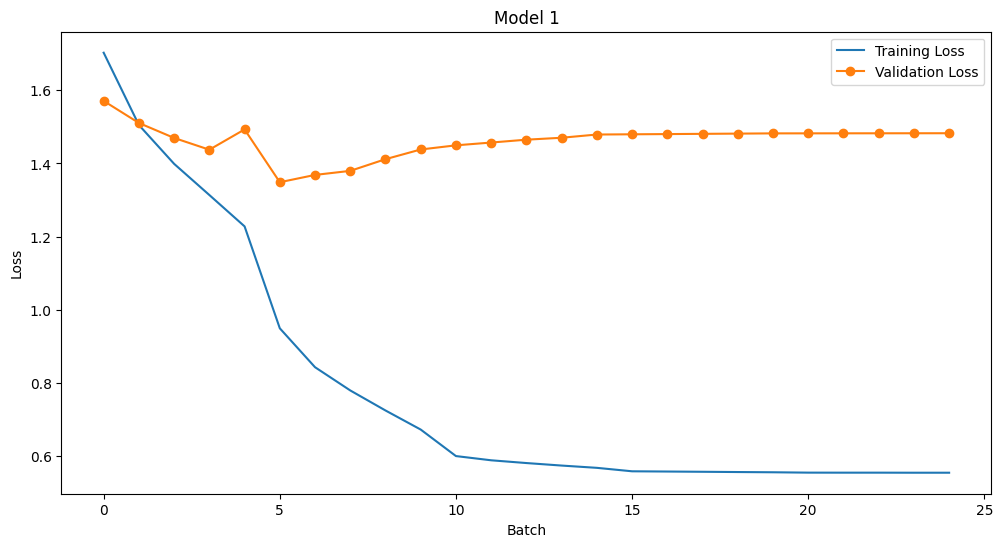

In [13]:
fcmodel = FCModel()
print("Training FCModel...")
train_losses, val_losses = train_model(fcmodel, trainloader, valloader)
torch.save(fcmodel.state_dict(), './models/fcmodel.pth')

test_model(fcmodel, testloader)
plot_losses(train_losses, val_losses, trainloader,'Model 1')

+ The FCModel demonstrates a **clear case of overfitting**, as evidenced by the divergence of training and validation loss after the 6th epoch. 
+ Despite achieving a low training loss, the model's performance on unseen data is below average, with a final accuracy of 55% on the test set. This suggests that the model's capacity may be too high, or it **lacks sufficient regularization**. Future iterations should focus on addressing this overfitting to improve generalization to unseen data.

### 2. Base Convolutions Model
**This is our "vanilla" model, the plain ice cream of our models.** It's got two convolutional layers that are like little detectives, scanning the image and picking up patterns. Then, it's got three fully connected layers that are like the brains of the operation, making sense of what the detectives found. On a technical note, these convolutional layers are responsible for feature extraction, while the fully connected layers perform the classification task.

![Example Image](../images/base_conv.png)

In [ ]:
class BaseConvModel(nn.Module):
    def __init__(self):
        super(BaseConvModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5) 
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        #print(x.size())
        x = x.view(-1, 64 * 6 * 6) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Training model BaseConvModel...
Epoch 1 - Training loss: 1.434, Validation loss: 1.175
Epoch 2 - Training loss: 1.057, Validation loss: 1.004
Epoch 3 - Training loss: 0.882, Validation loss: 0.934
Epoch 4 - Training loss: 0.759, Validation loss: 0.919
Epoch 5 - Training loss: 0.659, Validation loss: 0.897
Epoch 6 - Training loss: 0.446, Validation loss: 0.849
Epoch 7 - Training loss: 0.403, Validation loss: 0.874
Epoch 8 - Training loss: 0.377, Validation loss: 0.889
Epoch 9 - Training loss: 0.354, Validation loss: 0.912
Epoch 10 - Training loss: 0.333, Validation loss: 0.923
Epoch 11 - Training loss: 0.301, Validation loss: 0.927
Epoch 12 - Training loss: 0.297, Validation loss: 0.930
Epoch 13 - Training loss: 0.294, Validation loss: 0.934
Epoch 14 - Training loss: 0.292, Validation loss: 0.938
Epoch 15 - Training loss: 0.290, Validation loss: 0.941
Epoch 16 - Training loss: 0.286, Validation loss: 0.942
Epoch 17 - Training loss: 0.286, Validation loss: 0.943
Epoch 18 - Training loss:

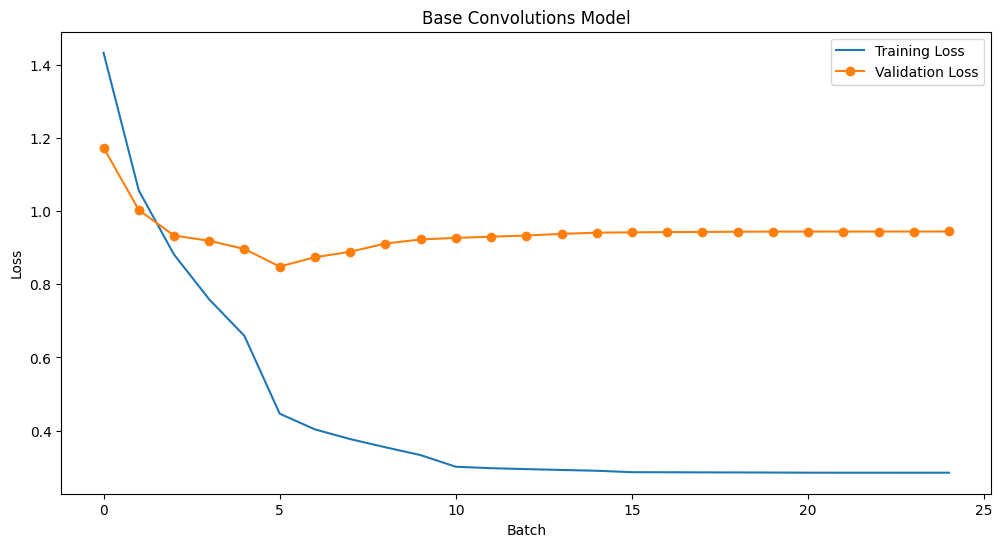

In [14]:
baseconvmodel = BaseConvModel()
print("Training model BaseConvModel...")
train_losses, val_losses = train_model(baseconvmodel, trainloader, valloader)
torch.save(baseconvmodel.state_dict(), './models/baseconvmodel.pth')

test_model(baseconvmodel, testloader)
plot_losses(train_losses, val_losses, trainloader,'Base Convolutions Model')

+ The BaseConvModel shows a significant improvement over the FCModel, achieving a final accuracy of 72% on the test set. However, similar to the FCModel, **it also exhibits signs of overfitting**, with the validation loss starting to increase after the 6th epoch while the training loss continues to decrease.
+ While the model's **complexity** allows it to fit the training data well, it may be **too high** for it to generalize effectively to unseen data. Future iterations could benefit from the introduction of regularization techniques or adjustments to the model's capacity.

### 3. Large Convolutions Model
This is the "double scoop" of our models. It's just like the BaseConvModel, but with two extra convolutional layers. It's like having extra detectives on the case, each one specializing in finding more complex patterns. Technically, these additional layers allow the model to **extract more complex and abstract features** from the input data, potentially improving its ability to classify complex patterns.

In [ ]:
class LargeConvModel(nn.Module):
    def __init__(self):
        super(LargeConvModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(256 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv4(x))
        x = x.view(-1, 256 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Training model Larger Conv Model...
Epoch 1 - Training loss: 1.615, Validation loss: 1.379
Epoch 2 - Training loss: 1.191, Validation loss: 1.063
Epoch 3 - Training loss: 0.985, Validation loss: 0.983
Epoch 4 - Training loss: 0.849, Validation loss: 0.967
Epoch 5 - Training loss: 0.745, Validation loss: 0.854
Epoch 6 - Training loss: 0.511, Validation loss: 0.773
Epoch 7 - Training loss: 0.457, Validation loss: 0.778
Epoch 8 - Training loss: 0.422, Validation loss: 0.798
Epoch 9 - Training loss: 0.392, Validation loss: 0.813
Epoch 10 - Training loss: 0.365, Validation loss: 0.837
Epoch 11 - Training loss: 0.323, Validation loss: 0.837
Epoch 12 - Training loss: 0.317, Validation loss: 0.844
Epoch 13 - Training loss: 0.314, Validation loss: 0.849
Epoch 14 - Training loss: 0.310, Validation loss: 0.853
Epoch 15 - Training loss: 0.307, Validation loss: 0.859
Epoch 16 - Training loss: 0.302, Validation loss: 0.860
Epoch 17 - Training loss: 0.301, Validation loss: 0.860
Epoch 18 - Training l

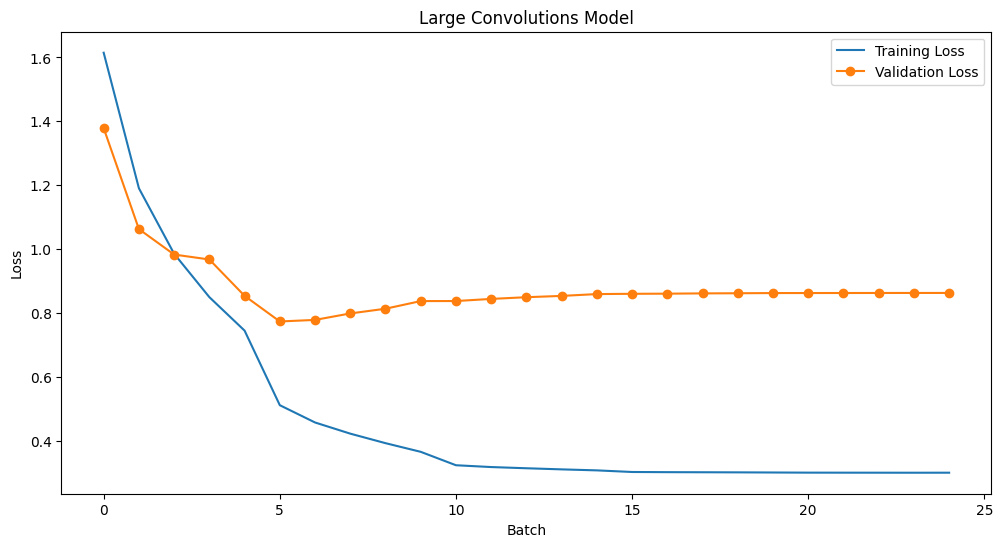

In [15]:
largeconvmodel = LargeConvModel()
print("Training model Larger Conv Model...")
train_losses, val_losses = train_model(largeconvmodel, trainloader, valloader)
torch.save(largeconvmodel.state_dict(), './models/largeconvmodel.pth')

test_model(largeconvmodel, testloader)
plot_losses(train_losses, val_losses, trainloader,'Large Convolutions Model')


+ The Larger Conv Model further improves the performance, reaching a final accuracy of 74% on the test set. However, **it also shows signs of overfitting**, with the validation loss starting to increase after the 6th epoch while the training loss continues to decrease. This indicates that the model might be **too complex and is fitting the training data too closely**, at the expense of its ability to generalize to unseen data. Future iterations should consider incorporating regularization techniques or adjusting the model's complexity to mitigate this overfitting.

### 4. Healthy Gradients Model: ~~Skip Connections~~ + Batch Normalization

This model is the "smooth operator". It's just like the LargeConvModel, but with Batch Normalization (BN). The BN is like a calming yoga instructor for our model, making sure the values stay balanced and centered, which helps the model learn better. In technical terms, BN normalizes the output from the activation function, reducing the amount by which the distribution of the activations shift during training. This can lead to faster convergence of the network.

- **Skip Connections**: These are a clever solution that allows the network to learn simpler representations in the earlier layers, and more complex features in the deeper layers. They do this by "skipping" some layers and directly feeding the output from one layer to a later layer. This helps to preserve the information from earlier in the network and mitigates the problem of vanishing gradients.

![Example Image](../images/skipconn.png)

- **Batch Normalization**: This technique normalizes the inputs to each layer, making the distribution of inputs consistent. This helps to smooth the optimization landscape, making it easier for the optimizer to find the global optimum. By smoothing the landscape, batch normalization can help to accelerate training and reduce overfitting.

![Example Image](../images/batchnorm.png)
    


In [42]:
class LargeConvBN(nn.Module):
    def __init__(self):
        super(LargeConvBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 3 * 3, 120)  # Adjusted based on the new output size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn4(self.conv4(x)))
        x = x.view(-1, 256 * 3 * 3)  # Adjusted based on the new output size
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Training Healthy Gradients Model...
Epoch 1 - Training loss: 1.345, Validation loss: 1.075
Epoch 2 - Training loss: 0.960, Validation loss: 0.916
Epoch 3 - Training loss: 0.783, Validation loss: 0.819
Epoch 4 - Training loss: 0.669, Validation loss: 0.730
Epoch 5 - Training loss: 0.571, Validation loss: 0.704
Epoch 6 - Training loss: 0.358, Validation loss: 0.598
Epoch 7 - Training loss: 0.300, Validation loss: 0.618
Epoch 8 - Training loss: 0.269, Validation loss: 0.630
Epoch 9 - Training loss: 0.239, Validation loss: 0.649
Epoch 10 - Training loss: 0.213, Validation loss: 0.671
Epoch 11 - Training loss: 0.179, Validation loss: 0.665
Epoch 12 - Training loss: 0.175, Validation loss: 0.668
Epoch 13 - Training loss: 0.172, Validation loss: 0.674
Epoch 14 - Training loss: 0.167, Validation loss: 0.678
Epoch 15 - Training loss: 0.163, Validation loss: 0.683
Epoch 16 - Training loss: 0.161, Validation loss: 0.683
Epoch 17 - Training loss: 0.161, Validation loss: 0.684
Epoch 18 - Training l

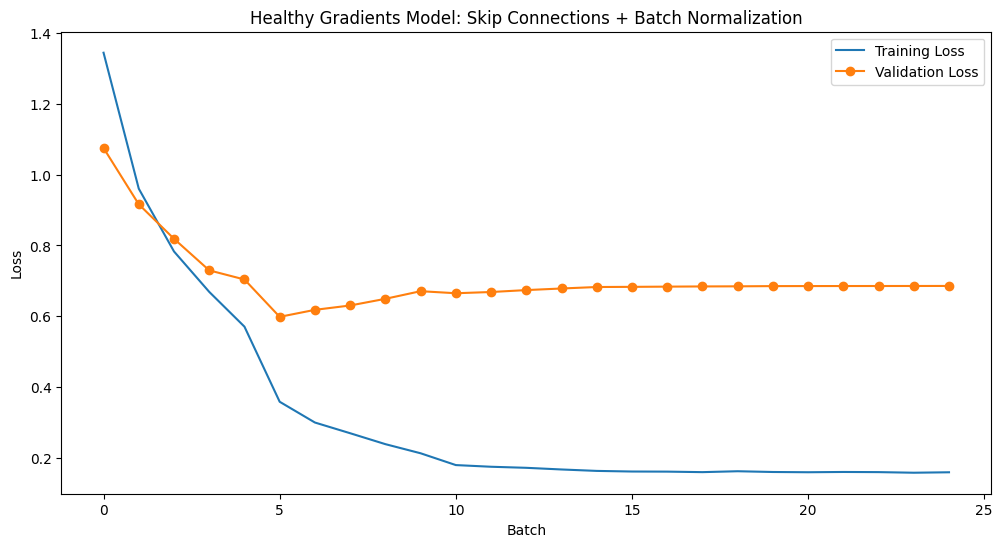

In [43]:
convgrad = LargeConvBN()
print("Training Healthy Gradients Model...")
train_losses, val_losses = train_model(convgrad, trainloader, valloader)
torch.save(convgrad.state_dict(), './models/convgrad.pth')

test_model(convgrad, testloader)
plot_losses(train_losses, val_losses, trainloader,'Healthy Gradients Model: Batch Normalization')

+ The Healthy Gradients Model shows the **best performance so far**, achieving a final accuracy of 79% on the test set. However, it **also starts to overfit** after the 6th epoch, as indicated by the increasing validation loss while the training loss continues to decrease. Despite this, the model's performance on the test set suggests that it has a better balance of complexity and generalization ability compared to the previous models. Future iterations could further improve performance by fine-tuning the model's complexity or introducing additional regularization techniques.

### 5. Regularized Model: Dropout
This model is the "survival of the fittest" model. It's like the LargeConvModel, but with Dropout. **Dropout is like a tough boot camp instructor**, randomly knocking out some neurons during training to make the others step up their game. This helps prevent overfitting and makes our model more robust. Technically, Dropout is a regularization technique that prevents overfitting by randomly setting a fraction of input units to 0 at each update during training time. This promotes generalization.

![Example Image](../images/dropout.png)


Deciding where to place dropout layers in a neural network can be a bit of an art, but there are some general guidelines
1. **After Activation Functions**: Dropout is typically applied after the activation function of a layer. This is because dropout works by "dropping out" (i.e., setting to zero) the outputs of some neurons, which are the values that come out of the activation function.

2. **After Fully Connected Layers**: In many architectures, dropout is often applied after fully connected layers (also known as dense layers). This is because fully connected layers have the most parameters and are therefore the most prone to overfitting.

3. **After Convolutional Layers**: Applying dropout after convolutional layers can also be effective, especially for larger networks. This can help to regularize the feature maps and make the network more robust to small changes in the input.

4. **Not Before Batch Normalization**: It's generally not recommended to apply dropout before batch normalization, because dropout would introduce noise into the statistics that batch normalization is trying to estimate.

In [44]:
class LargeConvDropout(nn.Module):
    def __init__(self):
        super(LargeConvDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv4(x))
        x = x.view(-1, 256 * 3 * 3)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Training Regularized Model...
Epoch 1 - Training loss: 1.893, Validation loss: 1.665
Epoch 2 - Training loss: 1.496, Validation loss: 1.397
Epoch 3 - Training loss: 1.319, Validation loss: 1.318
Epoch 4 - Training loss: 1.222, Validation loss: 1.209
Epoch 5 - Training loss: 1.140, Validation loss: 1.133
Epoch 6 - Training loss: 0.975, Validation loss: 1.031
Epoch 7 - Training loss: 0.935, Validation loss: 1.010
Epoch 8 - Training loss: 0.909, Validation loss: 1.012
Epoch 9 - Training loss: 0.887, Validation loss: 0.991
Epoch 10 - Training loss: 0.871, Validation loss: 1.004
Epoch 11 - Training loss: 0.846, Validation loss: 1.001
Epoch 12 - Training loss: 0.845, Validation loss: 0.989
Epoch 13 - Training loss: 0.843, Validation loss: 0.991
Epoch 14 - Training loss: 0.840, Validation loss: 0.976
Epoch 15 - Training loss: 0.840, Validation loss: 0.985
Epoch 16 - Training loss: 0.834, Validation loss: 0.994
Epoch 17 - Training loss: 0.837, Validation loss: 0.976
Epoch 18 - Training loss: 0

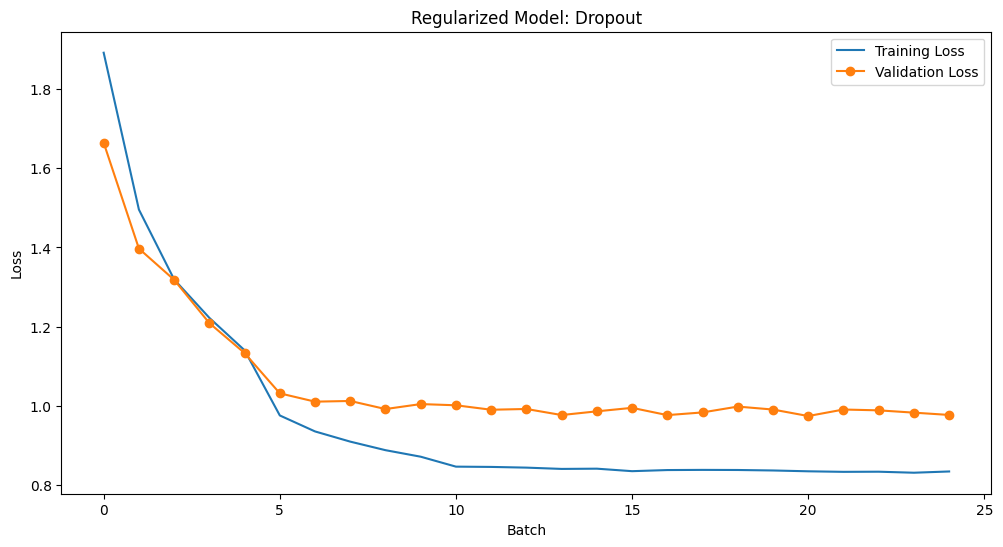

In [45]:
convreg = LargeConvDropout()
print("Training Regularized Model...")
train_losses, val_losses = train_model(convreg, trainloader, valloader)
torch.save(convreg.state_dict(), './models/convreg.pth')

test_model(convreg, testloader)
plot_losses(train_losses, val_losses, trainloader,'Regularized Model: Dropout')

+ The Regularized Model shows a final accuracy of 67% on the test set, which is lower than the Healthy Gradients Model. **However, it demonstrates a more stable learning process**, with the validation loss remaining relatively steady after the 6th epoch. 
+ This suggests that the regularization techniques used in this model have helped to **mitigate overfitting**. Despite the lower test accuracy, the Regularized Model's more stable learning process could potentially make it a more reliable choice for new, unseen data. Future iterations could focus on improving the model's capacity or fine-tuning the regularization parameters to further enhance performance.

### 6. Final Model: Batch Normalization + Dropout
This model is the "best of both worlds". It's got both the calming yoga instructor (Batch Normalization) and the tough boot camp instructor (Dropout). It's like a balanced diet for our model, helping it learn better and be more robust at the same time. Technically, this model combines the benefits of faster convergence from BN and improved generalization from Dropout, which can often lead to better performance on the validation set.

In [56]:
class LargeConvBNReg(nn.Module):
    def __init__(self):
        super(LargeConvBNReg, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.max_pool2d(x, 2)
        #print(x.shape)
        x = x.view(-1, 128 * 2 * 2)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Training Final Model...
Epoch 1 - Training loss: 1.742, Validation loss: 1.576
Epoch 2 - Training loss: 1.447, Validation loss: 1.339
Epoch 3 - Training loss: 1.316, Validation loss: 1.296
Epoch 4 - Training loss: 1.240, Validation loss: 1.187
Epoch 5 - Training loss: 1.172, Validation loss: 1.159
Epoch 6 - Training loss: 1.057, Validation loss: 1.085
Epoch 7 - Training loss: 1.022, Validation loss: 1.069
Epoch 8 - Training loss: 1.006, Validation loss: 1.063
Epoch 9 - Training loss: 0.990, Validation loss: 1.047
Epoch 10 - Training loss: 0.975, Validation loss: 1.041
Epoch 11 - Training loss: 0.958, Validation loss: 1.034
Epoch 12 - Training loss: 0.964, Validation loss: 1.038
Epoch 13 - Training loss: 0.955, Validation loss: 1.035
Epoch 14 - Training loss: 0.956, Validation loss: 1.021
Epoch 15 - Training loss: 0.953, Validation loss: 1.022
Epoch 16 - Training loss: 0.958, Validation loss: 1.027
Epoch 17 - Training loss: 0.953, Validation loss: 1.027
Epoch 18 - Training loss: 0.953, 

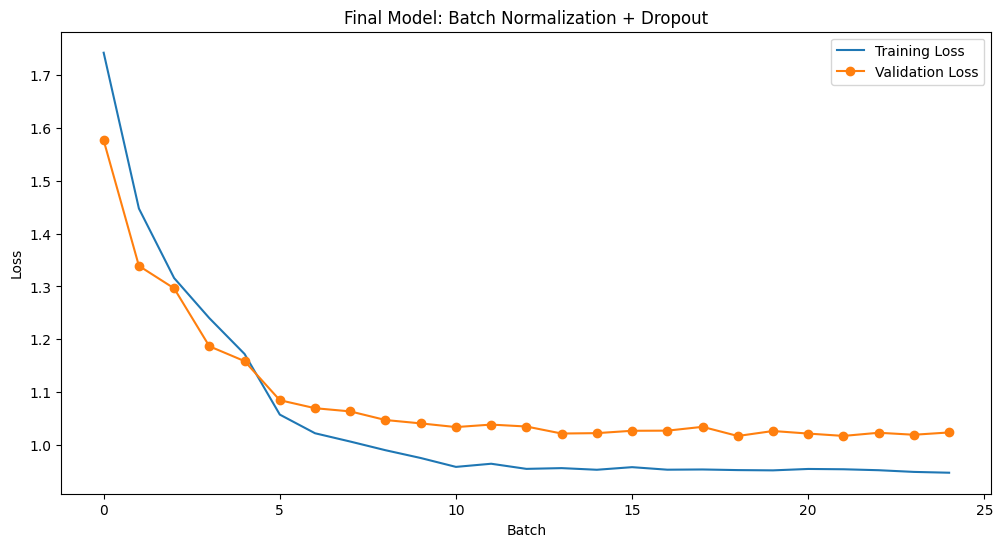

In [57]:
convgradiendreg = LargeConvBNReg()
print("Training Final Model...")
train_losses, val_losses = train_model(convgradiendreg, trainloader, valloader)
torch.save(convgradiendreg.state_dict(), './models/convgradiendreg.pth')

test_model(convgradiendreg, testloader)
plot_losses(train_losses, val_losses, trainloader,'Final Model: Batch Normalization + Dropout')

Training Final Model...
Epoch 1 - Training loss: 1.457, Validation loss: 1.218
Epoch 2 - Training loss: 1.139, Validation loss: 1.072
Epoch 3 - Training loss: 1.005, Validation loss: 1.011
Epoch 4 - Training loss: 0.917, Validation loss: 0.972
Epoch 5 - Training loss: 0.840, Validation loss: 0.894
Epoch 6 - Training loss: 0.697, Validation loss: 0.816
Epoch 7 - Training loss: 0.657, Validation loss: 0.802
Epoch 8 - Training loss: 0.643, Validation loss: 0.804
Epoch 9 - Training loss: 0.629, Validation loss: 0.789
Epoch 10 - Training loss: 0.615, Validation loss: 0.784
Epoch 11 - Training loss: 0.599, Validation loss: 0.790
Epoch 12 - Training loss: 0.592, Validation loss: 0.778
Epoch 13 - Training loss: 0.590, Validation loss: 0.783
Epoch 14 - Training loss: 0.589, Validation loss: 0.772
Epoch 15 - Training loss: 0.584, Validation loss: 0.776
Epoch 16 - Training loss: 0.582, Validation loss: 0.782
Epoch 17 - Training loss: 0.581, Validation loss: 0.772
Epoch 18 - Training loss: 0.580, 

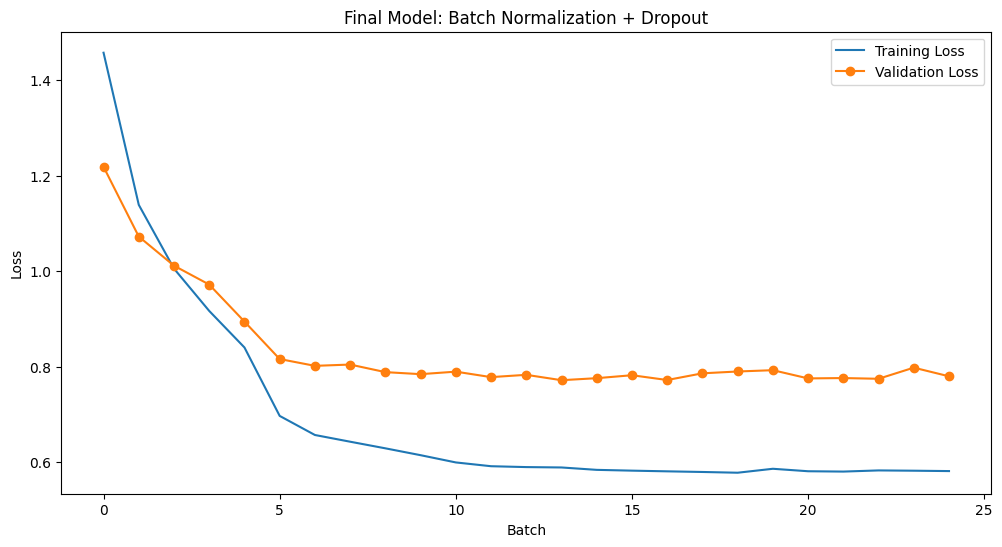

In [65]:
class LargeConvBNReg(nn.Module):
    def __init__(self):
        super(LargeConvBNReg, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.max_pool2d(x, 2)
        #print(x.shape)
        x = x.view(-1, 128 * 2 * 2)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
convgradiendreg2 = LargeConvBNReg()
print("Training Final Model...")
train_losses, val_losses = train_model(convgradiendreg2, trainloader, valloader)
torch.save(convgradiendreg2.state_dict(), './models/convgradiendreg2.pth')

test_model(convgradiendreg2, testloader)
plot_losses(train_losses, val_losses, trainloader,'Final Model: Batch Normalization + Dropout')

### Feature Maps

Files already downloaded and verified
frog


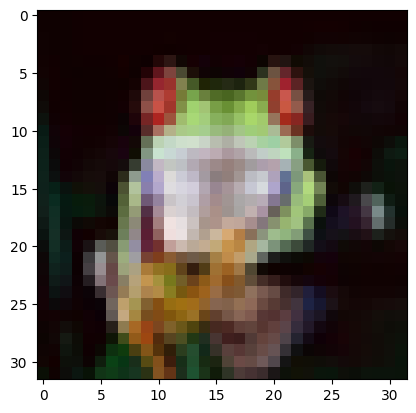

In [58]:
# Choose an image
i_img = 102

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
image, _ = dataset[i_img]

print(classes[_])
imshow(image)

In [59]:
def plot_feature_maps(model, dataset):

    model_children = list(model.children())

    conv_layers = []
    model_weights = []

    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i].children():
                if type(child) == nn.Conv2d:
                    model_weights.append(child.weight)
                    conv_layers.append(child)


    image, _ = dataset[i_img] 
    image = image.unsqueeze(0)

    outputs = []
    names = []

    n_layers_to_plot = len(conv_layers)
    print(f"Total convolution layers: {n_layers_to_plot}")

    for layer in conv_layers:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))

    # Create a function to normalize the feature maps so they can be visualized
    def normalize(image):
        return (image - image.min()) / (image.max() - image.min())

# Define the figure size for the entire plot
    fig_width = 4*n_layers_to_plot
    fig_height = 4
    fig, axs = plt.subplots(1, n_layers_to_plot, figsize=(fig_width, fig_height))

    if n_layers_to_plot == 1: 
        axs = [axs]

    for i, ax in enumerate(axs):
        feature_map = outputs[i][0]
        if feature_map.shape[0] > 3: 
            feature_map = torch.sum(feature_map, axis=0)
        feature_map = normalize(feature_map)
        ax.imshow(feature_map.cpu().detach(), cmap='viridis')
        ax.set_title(names[i].split('(')[0], fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Feature Maps: Base Conv Model
Total convolution layers: 2


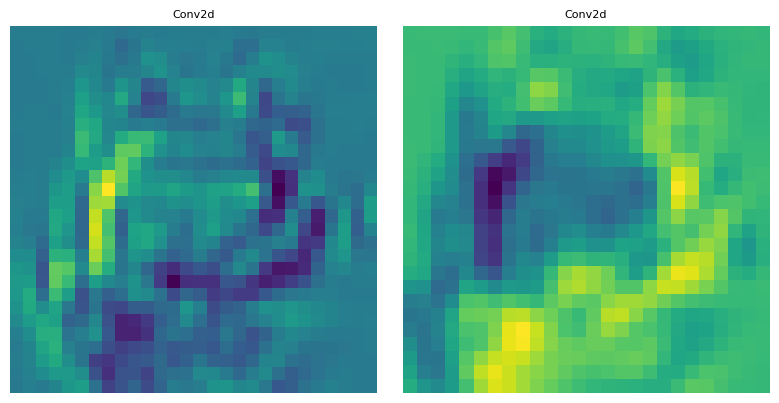

In [60]:
print("Feature Maps: Base Conv Model")
trained_model = BaseConvModel()
trained_model.load_state_dict(torch.load('./models/baseconvmodel.pth'))
trained_model.eval()
plot_feature_maps(trained_model, dataset)

Feature Maps: Large Conv Model
Total convolution layers: 4


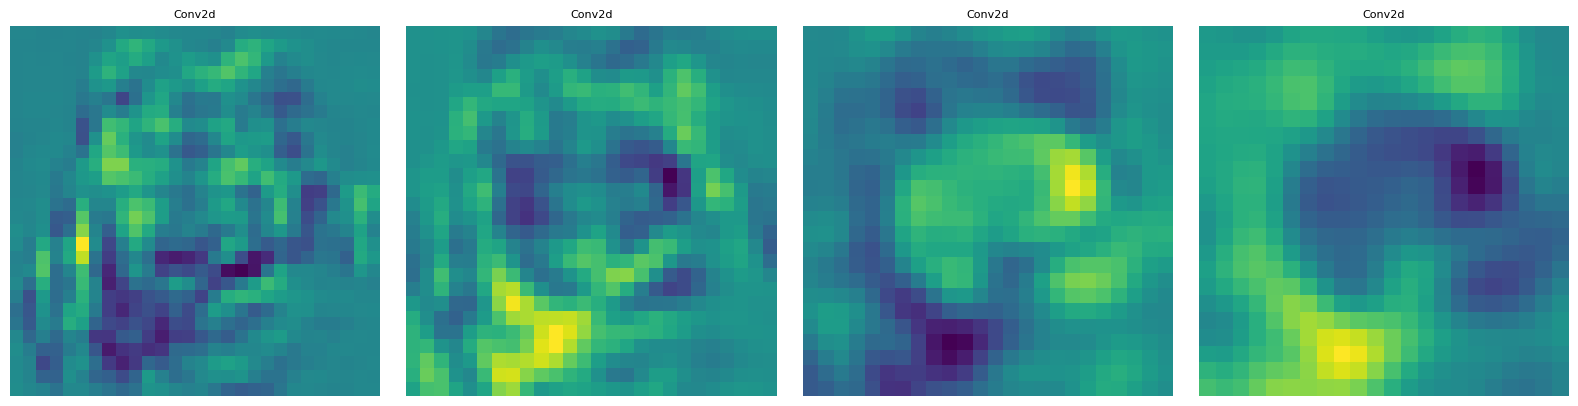

In [61]:
print("Feature Maps: Large Conv Model")
trained_model = LargeConvModel()
trained_model.load_state_dict(torch.load('./models/largeconvmodel.pth'))
trained_model.eval()
plot_feature_maps(trained_model, dataset)

Feature Maps: Large Conv Model with Batch Normalization
Total convolution layers: 4


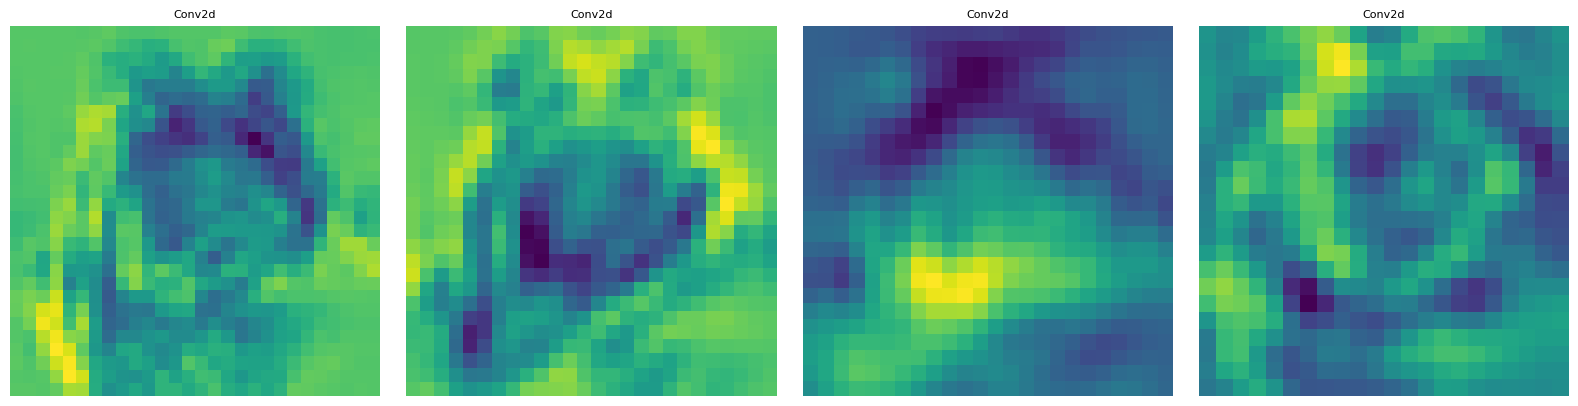

In [62]:
print("Feature Maps: Large Conv Model with Batch Normalization")
trained_model = LargeConvBN()
trained_model.load_state_dict(torch.load('./models/convgrad.pth'))
trained_model.eval()
plot_feature_maps(trained_model, dataset)

Feature Maps: Large Conv Model with Dropout
Total convolution layers: 4


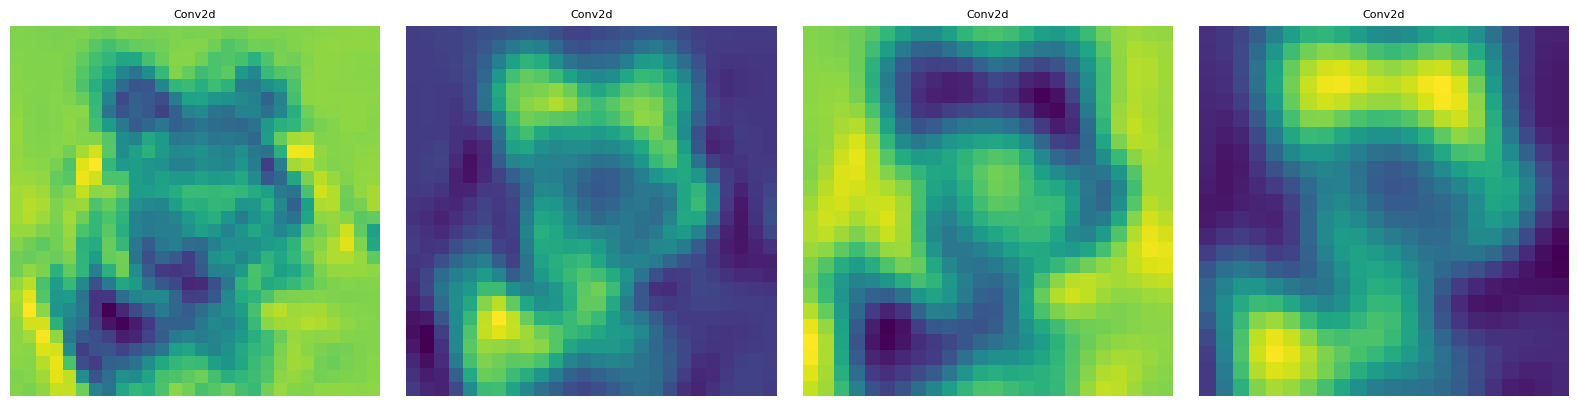

In [63]:
print("Feature Maps: Large Conv Model with Dropout")
trained_model = LargeConvDropout()
trained_model.load_state_dict(torch.load('./models/convreg.pth'))
trained_model.eval()
plot_feature_maps(trained_model, dataset)

Feature Maps: Large Conv Model with Skip Connections, Batch Normalization and Dropout
Total convolution layers: 3


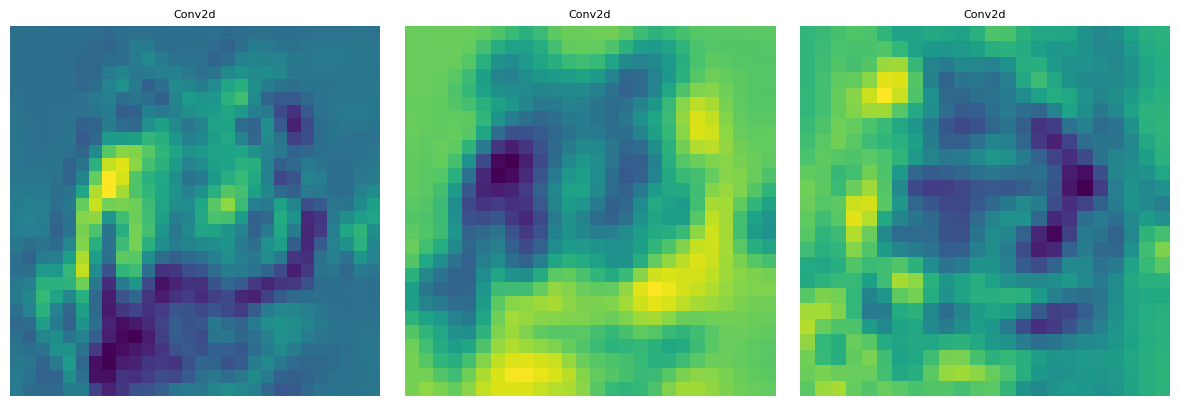

In [64]:
print("Feature Maps: Large Conv Model with Skip Connections, Batch Normalization and Dropout")
trained_model = LargeConvBNReg()
trained_model.load_state_dict(torch.load('./models/convgradiendreg.pth'))
trained_model.eval()
plot_feature_maps(trained_model, dataset)